# **Microproyecto 1:** Generación de Notas Musicales

El objetivo de este Notebook es entrenar un modelo de secuencia que, a partir de un contexto de notas previas (`pitch`, `step`, `duration`, y opcionalmente `velocity`), prediga la siguiente nota con las mismas características, siguiendo el estilo de un compositor y un instrumento de los presentes en el dataset.

Presentado por:
- Manuel Estévez Bretón - me.estevez-breton10@uniandes.edu.co
- Ling Lung Zuñiga - l.lung@uniandes.edu.co
- Victoria Orellana Guerrero - v.orellana@uniandes.edu.co
- Jorge Paternina Montiel - j.paterninam@uniandes.edu.co
- Benjamin Perdomo Morales - b.perdomom@uniandes.edu.co

## **Notebook Set-up**

In [8]:
# Instalar dependencias
# !sudo apt install -y fluidsynth
# %pip install pretty_midi midi2audio torch numpy pandas matplotlib tqdm scikit-learn ipywidgets

In [9]:
# Importaciones básicas
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import glob

import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Visualización
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from tqdm import tqdm
import scipy.io.wavfile as wavfile

# Audio/MIDI
import pretty_midi
from midi2audio import FluidSynth

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn.functional as F

# Reproducibilidad
import random


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

print("Librarías importadas correctamente. Torch CUDA:", torch.cuda.is_available())

Librarías importadas correctamente. Torch CUDA: True


In [10]:
# Constantes del proyecto
# Se configuran en un solo lugar para facilitar cambios futuros
SEQ_LENGTH = 128
INPUT_FEATURES = 4
OUTPUT_FEATURES = 4

## **Carga de Datos**

In [11]:
# Ruta principal donde se encuentran las carpetas de los compositores
base_path = "/content/dataset/music_artist"

# Path para extraer pistas de un único compositor
composer = "mozart"
composer_path = os.path.join(base_path, composer)
midi_files = glob.glob(os.path.join(composer_path, "*.mid"))

print(
    f"Se encontraron {len(midi_files)} archivos MIDI para el compositor: '{composer}'"
)

Se encontraron 21 archivos MIDI para el compositor: 'mozart'


In [12]:
def list_available_instruments(midi_files):
    """
    Analiza una lista de archivos MIDI y devuelve una lista de todos los
    nombres de instrumentos únicos encontrados.
    """
    instrument_names = set()

    print("Buscando instrumentos en los archivos MIDI...")
    for midi_path in tqdm(midi_files, desc="Analizando archivos"):
        try:
            pm = pretty_midi.PrettyMIDI(midi_path)
            for instrument in pm.instruments:
                instrument_name = pretty_midi.program_to_instrument_name(
                    instrument.program
                )
                instrument_names.add(instrument_name)
        except Exception as e:
            print(f"Ocurrió un error menor en el archivo {midi_path}: {e}")
            continue
    return sorted(list(instrument_names))


available_instruments = list_available_instruments(midi_files)
print("\n--- Instrumentos Disponibles ---")
for instrument in available_instruments:
    print(f"{instrument}")

# Nuestro approach para seleccionar el instrumento será en función de su frecuencia
selected_instrument = max(set(available_instruments), key=available_instruments.count)
print(f"\nEl instrumento seleccionado es: {selected_instrument}")

Buscando instrumentos en los archivos MIDI...


Analizando archivos: 100%|██████████| 21/21 [00:01<00:00, 11.80it/s]


--- Instrumentos Disponibles ---
Acoustic Grand Piano

El instrumento seleccionado es: Acoustic Grand Piano


In [13]:
def extract_notes_by_instrument(midi_path, target_instrument_name):
    """
    Función para abrir un archivo MIDI y extraer las notas de un instrumento.
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)

        instrument_to_extract = None
        for instrument in pm.instruments:
            instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
            # Ahora la comparación usa la variable correcta que pasaste como parámetro
            if instrument_name == target_instrument_name:
                instrument_to_extract = instrument
                break

        if not instrument_to_extract:
            return pd.DataFrame()

        notes = instrument_to_extract.notes
        sorted_notes = sorted(notes, key=lambda note: note.start)

        prev_start = 0
        extracted_notes = []

        for note in sorted_notes:
            start = note.start
            end = note.end

            pitch = note.pitch
            step = start - prev_start
            duration = end - start
            velocity = note.velocity

            extracted_notes.append(
                {
                    "pitch": pitch,
                    "step": step,
                    "duration": duration,
                    "velocity": velocity,
                }
            )

            prev_start = start

        return pd.DataFrame(extracted_notes)

    except Exception as e:
        return pd.DataFrame()


df_test = extract_notes_by_instrument(midi_files[0], selected_instrument)
print(df_test.head())

   pitch      step  duration  velocity
0     84  0.096321  0.105953        66
1     83  0.096321  0.105953        68
2     84  0.096320  0.105953        69
3     89  0.096321  0.106272        70
4     84  0.096320  0.109086        63


In [ ]:
all_composer_notes = []
print(f"\nProcesando todos los archivos de '{composer}'")
for file in tqdm(midi_files, desc=f"Extrayendo notas"):
    # Use the selected_instrument variable determined earlier
    notes_df = extract_notes_by_instrument(file, selected_instrument)
    if not notes_df.empty:
        all_composer_notes.append(notes_df)

# Concatenamos todos los DataFrames de la lista en uno solo
if all_composer_notes:
    full_dataset = pd.concat(all_composer_notes, ignore_index=True)
    print(f"Número total de notas extraídas: {len(full_dataset)}")
    print("Primeras 10 filas del dataset completo:")
    print(full_dataset.head(10))
else:
    print(
        "\nNo se pudieron extraer notas de ningún archivo. Revisar rutas o archivos MIDI."
    )


Procesando todos los archivos de 'mozart'


Extrayendo notas: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]

Número total de notas extraídas: 38545
Primeras 10 filas del dataset completo:
   pitch      step  duration  velocity
0     84  0.096321  0.105953        66
1     83  0.096321  0.105953        68
2     84  0.096320  0.105953        69
3     89  0.096321  0.106272        70
4     84  0.096320  0.109086        63
5     82  0.099516  0.105277        70
6     81  0.095706  0.105277        66
7     80  0.095706  0.105277        64
8     81  0.095706  0.105277        64
9     84  0.095706  0.105592        70


**¿Por qué no incluimos un ID de la pista en el dataset?**
Nuestro objetivo es que el modelo aprenda el lenguaje musical de un compositor, no que memorice canciones específicas. Por tal motivo, tratamos toda su obra como un único texto musical. El objetivo es encontrar patrones de su estilo, no sobreajustarnos a una canción.

** Análisis descriptivo de las variables

Estadísticas descriptivas:


,pitch,step,duration,velocity
count,38545.000000,38545.000000,38545.000000,38545.000000
mean,74.126553,0.219299,0.237060,57.234842
std,6.194095,0.264377,0.259454,11.952000
min,40.000000,0.000000,0.003759,21.000000
25%,70.000000,0.096320,0.102740,49.000000
50%,74.000000,0.118045,0.124689,56.000000
75%,79.000000,0.247934,0.265816,65.000000
max,91.000000,6.539590,6.642802,110.000000


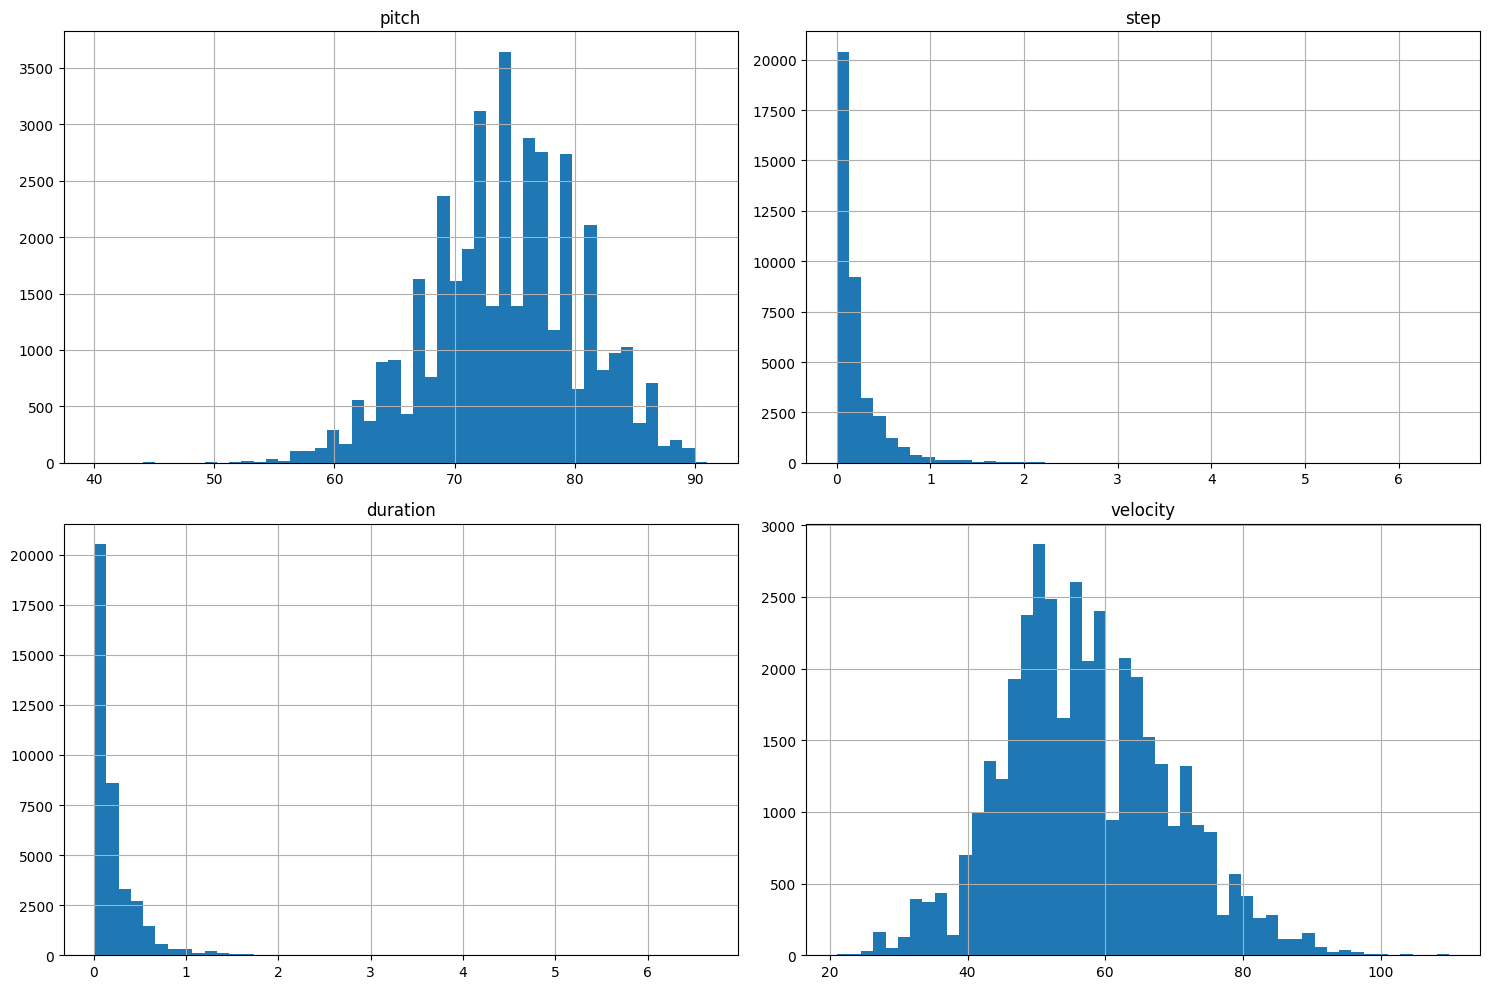

In [15]:
# Analizar distribuciones
print("Estadísticas descriptivas:")
display(full_dataset[["pitch", "step", "duration", "velocity"]].describe())

# Dibujar histogramas para visualizar distribuciones
full_dataset[["pitch", "step", "duration", "velocity"]].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

## **Transformación de datos**

### Discretización y mapeo
La estrategia de tranformación elegida para el entrenamiento será convertir los valores en variables discretas.
- Pitch: Es en su mayoría enteros, con un largo considerable (40-91). Se puede tratar como una variable categórica, redondeando al entero más cercano.
- Velocity: En su mayoría enteros en un rango (21-110). Se redondea al entero más cercano.
- Step and Duration: Valores continuos. Se usa un agrupamiento basado en cuartiles para manejar la distribución sesgada. Se utilizan 50 grupos

In [16]:
# Implementar discretización
full_dataset["pitch_discrete"] = np.round(full_dataset["pitch"]).astype(int)
full_dataset["velocity_discrete"] = np.round(full_dataset["velocity"]).astype(int)

# Se usa qcut for para agrupamiento pasado en cuartiles,
full_dataset["step_discrete"], step_bins = pd.qcut(
    full_dataset["step"], q=50, labels=False, retbins=True, duplicates="drop"
)
full_dataset["duration_discrete"], duration_bins = pd.qcut(
    full_dataset["duration"], q=50, labels=False, retbins=True, duplicates="drop"
)

# Se convierten los valores discretos a entero
full_dataset["step_discrete"] = full_dataset["step_discrete"].astype(int)
full_dataset["duration_discrete"] = full_dataset["duration_discrete"].astype(int)

# Se crea una representación combinada (vocabulario), usando una representaciún única de caracteres para la combinación
# Create a unique string representation for each combination of discrete features
full_dataset["note_event"] = full_dataset.apply(
    lambda row: f"{int(row['pitch_discrete'])}_{int(row['step_discrete'])}_{int(row['duration_discrete'])}_{int(row['velocity_discrete'])}",
    axis=1,
)

# Se crea un mapeo de vocabulario, asignando eventos ùnicos de notas a IDs enteros
unique_note_events = full_dataset["note_event"].unique()
note_event_to_id = {event: i for i, event in enumerate(unique_note_events)}
id_to_note_event = {i: event for event, i in note_event_to_id.items()}

# Se añaden los IDs al dataframe
full_dataset["note_event_id"] = full_dataset["note_event"].map(note_event_to_id)

print("\nDatos discretos con IDs de eventos de notas:")
display(
    full_dataset[
        [
            "pitch",
            "pitch_discrete",
            "step",
            "step_discrete",
            "duration",
            "duration_discrete",
            "velocity",
            "velocity_discrete",
            "note_event",
            "note_event_id",
        ]
    ].head()
)
print(
    f"\nNúmero de eventos de notas únicos (tamaño del vocabulario): {len(unique_note_events)}"
)

# Se almacena el mapeo (step_bins, duration_bins, note_event_to_id, id_to_note_event), que será necesario más adelante para la transformación inversa y la búsqueda de vocabulario durante la generación
discretization_mappings = {
    "step_bins": step_bins,
    "duration_bins": duration_bins,
    "note_event_to_id": note_event_to_id,
    "id_to_note_event": id_to_note_event,
}


Datos discretos con IDs de eventos de notas:


,pitch,pitch_discrete,step,step_discrete,duration,duration_discrete,velocity,velocity_discrete,note_event,note_event_id
0,84,84,0.096321,7,0.105953,14,66,66,84_7_14_66,0
1,83,83,0.096321,7,0.105953,14,68,68,83_7_14_68,1
2,84,84,0.096320,7,0.105953,14,69,69,84_7_14_69,2
3,89,89,0.096321,7,0.106272,14,70,70,89_7_14_70,3
4,84,84,0.096320,7,0.109086,16,63,63,84_7_16_63,4



Número de eventos de notas únicos (tamaño del vocabulario): 18738


### Preparación de datos para clasificación
La música clásica, como la de Mozart, suele estar escrita en compases (8 notas). Por ende, se seleccionarán múltiplos de ese valor para la creación de las sequencias.

In [ ]:
# Constantes del proyecto
SEQ_LENGTH = 128  # Tamaño de la secuencia
INPUT_FEATURES = 4
OUTPUT_FEATURES = 4

train_size_threshold = int(full_dataset.shape[0] * 0.8)

train_data_clf = full_dataset.iloc[:train_size_threshold, :]
test_data_clf = full_dataset.iloc[train_size_threshold:, :]

# La variable objetivo será note_event_id
y_train_clf = train_data_clf["note_event_id"]
y_test_clf = test_data_clf["note_event_id"]

# Se mantienen las columnas de características originales para crear secuencias de entrada
X_train_clf = train_data_clf[["pitch", "step", "duration", "velocity"]]
X_test_clf = test_data_clf[["pitch", "step", "duration", "velocity"]]


# Se crea una función para generar secuencias de entrada y etiquetas objetivo
def create_sequences_clf(features_df, target_series, seq_lenght):
    xs, ys = [], []

    if not features_df.index.equals(target_series.index):
        raise ValueError("Features and target must have the same index.")

    for i in range(len(features_df) - seq_lenght):
        x = features_df.iloc[i : (i + seq_lenght), :].values
        y = target_series.iloc[i + seq_lenght]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Se aplica la función create_sequences
SEQ_LENGTH = 128
X_train_clf_np, y_train_clf_np = create_sequences_clf(
    X_train_clf, y_train_clf, SEQ_LENGTH
)
X_test_clf_np, y_test_clf_np = create_sequences_clf(X_test_clf, y_test_clf, SEQ_LENGTH)

# Se convierten las matrices NumPy a tensores de PyTorch
X_train_clf_tensor = torch.from_numpy(X_train_clf_np).float()
y_train_clf_tensor = torch.from_numpy(y_train_clf_np).long()

X_test_clf_tensor = torch.from_numpy(X_test_clf_np).float()
y_test_clf_tensor = torch.from_numpy(y_test_clf_np).long()

# Se crean nuevos objetos TensorDataset
dataset_train_clf = TensorDataset(X_train_clf_tensor, y_train_clf_tensor)
dataset_test_clf = TensorDataset(X_test_clf_tensor, y_test_clf_tensor)

# Se imprimen los tamaños para verificar
print("Tamaños después de crear secuencias para clasificación:")
print("X_train_clf_tensor shape:", X_train_clf_tensor.shape)
print("y_train_clf_tensor shape:", y_train_clf_tensor.shape)
print("X_test_clf_tensor shape:", X_test_clf_tensor.shape)
print("y_test_clf_tensor shape:", y_test_clf_tensor.shape)

# Se obtiene el tamaño del vocabulario
VOCAB_SIZE = len(discretization_mappings["note_event_to_id"])
print(f"Tamaño del vocabulario: {VOCAB_SIZE}")

Tamaños después de crear secuencias para clasificación:
X_train_clf_tensor shape: torch.Size([30708, 128, 4])
y_train_clf_tensor shape: torch.Size([30708])
X_test_clf_tensor shape: torch.Size([7581, 128, 4])
y_test_clf_tensor shape: torch.Size([7581])
Tamaño del vocabulario: 18738


## **Instanciamiento de arquitecturas a comparar**
Se van a comparar dos arquitecturas: GRU y LSTM

In [18]:
class GRUNet_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, hn = self.gru(x, h0)

        out = out[:, -1, :]

        out = self.dropout(out)

        out = self.fc(out)

        # No Softmax here; CrossEntropyLoss will handle it.

        return out


class LSTMNet_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Get output from the last time step
        out = out[:, -1, :]

        # Apply dropout for regularization
        out = self.dropout(out)

        # Project to output size
        out = self.fc(out)

        return out

## Entrenamiento y evaluación

In [19]:
INPUT_FEATURES = 4
OUTPUT_FEATURES = 4
HIDDEN_UNITS = 512

INPUT_FEATURES = 4
HIDDEN_UNITS = 512
VOCAB_SIZE = len(discretization_mappings["note_event_to_id"])

model_gru_clf = GRUNet_Classifier(
    input_size=INPUT_FEATURES, hidden_size=HIDDEN_UNITS, output_size=VOCAB_SIZE
)

BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

criterion_clf = nn.CrossEntropyLoss()  # Use the classification criterion
optimizer_gru_clf = optim.Adam(model_gru_clf.parameters(), lr=LEARNING_RATE)

dataloader_train_clf = DataLoader(
    dataset_train_clf, batch_size=BATCH_SIZE, shuffle=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gru_clf.to(device)
model_gru_clf.train()

print(f"Inicia el entrenamiento de GRU en {device}")

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for seqs, labels in dataloader_train_clf:
        seqs, labels = seqs.to(device), labels.to(device)  # labels are already long()

        optimizer_gru_clf.zero_grad()
        outputs = model_gru_clf(seqs)
        loss = criterion_clf(outputs, labels)

        loss.backward()
        optimizer_gru_clf.step()

        running_loss += loss.item() * seqs.size(0)

    epoch_loss = running_loss / len(dataset_train_clf)
    print(f"Clasificador GRU epoch [{epoch+1}/{NUM_EPOCHS}], Pérdida: {epoch_loss:.4f}")

print("Entrenamiento de clasificador GRU finalizado")


def evaluate_model_clf(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for seqs, labels in data_loader:
            seqs, labels = seqs.to(device), labels.to(device)

            outputs = model(seqs)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * seqs.size(0)

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    predictions = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return avg_loss, predictions, targets


# --- Evaluación del Clasificador GRU ---
dataloader_test_clf = DataLoader(dataset_test_clf, batch_size=BATCH_SIZE, shuffle=False)
gru_clf_val_loss, gru_clf_val_preds, gru_clf_val_targets = evaluate_model_clf(
    model_gru_clf, dataloader_test_clf, criterion_clf, device
)

print(f"\nEvaluación del Clasificador GRU finalizada.")
print(f"Pérdida media de Entropía Cruzada: {gru_clf_val_loss:.4f}")


model_lstm_clf = LSTMNet_Classifier(
    input_size=INPUT_FEATURES, hidden_size=HIDDEN_UNITS, output_size=VOCAB_SIZE
)

optimizer_lstm_clf = optim.Adam(model_lstm_clf.parameters(), lr=LEARNING_RATE)

model_lstm_clf.to(device)
model_lstm_clf.train()

print(f"\nInicia el entrenamiento de clasificador LSTM en {device}")

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for seqs, labels in dataloader_train_clf:
        seqs, labels = seqs.to(device), labels.to(device)  # labels are already long()

        optimizer_lstm_clf.zero_grad()
        outputs = model_lstm_clf(seqs)
        loss = criterion_clf(outputs, labels)

        loss.backward()
        optimizer_lstm_clf.step()

        running_loss += loss.item() * seqs.size(0)

    epoch_loss = running_loss / len(dataset_train_clf)
    print(
        f"Clasificador LSTM epoch [{epoch+1}/{NUM_EPOCHS}], Pérdida: {epoch_loss:.4f}"
    )

print("Entrenamiento de clasificador LSTM finalizado")

# --- Evaluación del Clasificador LSTM ---
lstm_clf_val_loss, lstm_clf_val_preds, lstm_clf_val_targets = evaluate_model_clf(
    model_lstm_clf, dataloader_test_clf, criterion_clf, device
)

print(f"\nEvaluación del Clasificador LSTM finalizada.")
print(f"Pérdida media de Entropía Cruzada: {lstm_clf_val_loss:.4f}")

Inicia el entrenamiento de GRU en cuda
Clasificador GRU epoch [1/20], Pérdida: 10.1136
Clasificador GRU epoch [2/20], Pérdida: 9.9585
Clasificador GRU epoch [3/20], Pérdida: 9.9292
Clasificador GRU epoch [4/20], Pérdida: 9.9243
Clasificador GRU epoch [5/20], Pérdida: 9.8878
Clasificador GRU epoch [6/20], Pérdida: 9.9601
Clasificador GRU epoch [7/20], Pérdida: 10.0030
Clasificador GRU epoch [8/20], Pérdida: 9.9667
Clasificador GRU epoch [9/20], Pérdida: 10.0969
Clasificador GRU epoch [10/20], Pérdida: 10.0421
Clasificador GRU epoch [11/20], Pérdida: 10.0880
Clasificador GRU epoch [12/20], Pérdida: 10.0593
Clasificador GRU epoch [13/20], Pérdida: 10.1173
Clasificador GRU epoch [14/20], Pérdida: 10.1941
Clasificador GRU epoch [15/20], Pérdida: 10.2218
Clasificador GRU epoch [16/20], Pérdida: 10.3366
Clasificador GRU epoch [17/20], Pérdida: 10.3240
Clasificador GRU epoch [18/20], Pérdida: 10.3423
Clasificador GRU epoch [19/20], Pérdida: 10.3612
Clasificador GRU epoch [20/20], Pérdida: 10.3

### Cálculo de la perplejidad
La perplejidad permitirá comparar los modelos para escoger el mejor

In [20]:
def calculate_perplexity(predicted_logits, true_labels):
    """
    Calcula la perplexity a partir de los logits predichos y las etiquetas discretas verdaderas.

    Args:
        predicted_logits (torch.Tensor): Tensor de logits predichos (antes de softmax).
        true_labels (torch.Tensor): Tensor de índices de clase objetivo verdaderos (tipo long).

    Returns:
        float: La perplexity calculada.
    """
    probabilities = F.softmax(predicted_logits, dim=1)

    nll = F.nll_loss(torch.log(probabilities), true_labels, reduction="sum")

    average_nll = nll / true_labels.size(0)

    perplexity = torch.exp(average_nll)

    return perplexity

In [21]:
# Convertir los arreglos numpy de vuelta a tensores para el cálculo de perplexity
gru_clf_val_preds_tensor = torch.from_numpy(gru_clf_val_preds)
gru_clf_val_targets_tensor = torch.from_numpy(
    gru_clf_val_targets
).long()  # Asegurarse de que el objetivo sea de tipo long

lstm_clf_val_preds_tensor = torch.from_numpy(lstm_clf_val_preds)
lstm_clf_val_targets_tensor = torch.from_numpy(
    lstm_clf_val_targets
).long()  # Asegurarse de que el objetivo sea de tipo long

# Calcular perplexity para el Clasificador GRU
gru_clf_perplexity = calculate_perplexity(
    gru_clf_val_preds_tensor, gru_clf_val_targets_tensor
)
print(f"GRU Classifier Validation Perplexity: {gru_clf_perplexity.item():.4f}")

# Calcular perplexity para el Clasificador LSTM
lstm_clf_perplexity = calculate_perplexity(
    lstm_clf_val_preds_tensor, lstm_clf_val_targets_tensor
)
print(f"LSTM Classifier Validation Perplexity: {lstm_clf_perplexity.item():.4f}")

print("--- Comparación de Modelos ---")
print(f"Perplexity del Clasificador GRU Perplexity: {gru_clf_perplexity.item():.4f}")
print(f"Perplexity del Clasificador LSTM: {lstm_clf_perplexity.item():.4f}")

GRU Classifier Validation Perplexity: 110974896.0000
LSTM Classifier Validation Perplexity: 7275229.5000
--- Comparación de Modelos ---
Perplexity del Clasificador GRU Perplexity: 110974896.0000
Perplexity del Clasificador LSTM: 7275229.5000


In [22]:
## Escogencia del mejor modelo

# Interpretación y Comparación
print("\n--- Interpretación ---")
print(
    "La perplejidad (perplexity) es una medida de qué tan bien un modelo de probabilidad predice una muestra."
)
print(
    "En el contexto de esta tarea de generación de música, indica cuán 'sorprendido' está el modelo por el evento real de la siguiente nota en los datos de validación."
)
print(
    "Un puntaje de perplexity más bajo significa que el modelo está menos sorprendido y, por lo tanto, es mejor para predecir el siguiente evento de nota en función de la secuencia anterior."
)
print(
    "Se puede interpretar como el promedio ponderado del número de opciones que tiene el modelo en cada paso."
)

print("\n--- Comparación de Modelos basada en Perplexity ---")
if gru_clf_perplexity < lstm_clf_perplexity:
    print(
        "Basado en la perplejidad, el modelo de Clasificador GRU tuvo un mejor rendimiento."
    )
    print(
        f"La perplejidad del modelo GRU ({gru_clf_perplexity.item():.4f}) es más baja que la perplejidad del modelo LSTM ({lstm_clf_perplexity.item():.4f})."
    )
else:
    print(
        "Basado en la perplejidad, el modelo de Clasificador LSTM tuvo un mejor rendimiento."
    )
    print(
        f"La perplejidad del modelo LSTM ({lstm_clf_perplexity.item():.4f}) es más baja que la perplejidad del modelo GRU ({gru_clf_perplexity.item():.4f})."
    )

print(
    "\nEsto sugiere que el modelo con la perplejidad más baja es mejor para capturar los patrones y secuencias en los eventos de notas discretas, lo que lleva a predicciones más probables de la siguiente nota."
)


--- Interpretación ---
La perplejidad (perplexity) es una medida de qué tan bien un modelo de probabilidad predice una muestra.
En el contexto de esta tarea de generación de música, indica cuán 'sorprendido' está el modelo por el evento real de la siguiente nota en los datos de validación.
Un puntaje de perplexity más bajo significa que el modelo está menos sorprendido y, por lo tanto, es mejor para predecir el siguiente evento de nota en función de la secuencia anterior.
Se puede interpretar como el promedio ponderado del número de opciones que tiene el modelo en cada paso.

--- Comparación de Modelos basada en Perplexity ---
Basado en la perplejidad, el modelo de Clasificador LSTM tuvo un mejor rendimiento.
La perplejidad del modelo LSTM (7275229.5000) es más baja que la perplejidad del modelo GRU (110974896.0000).

Esto sugiere que el modelo con la perplejidad más baja es mejor para capturar los patrones y secuencias en los eventos de notas discretas, lo que lleva a predicciones má

## Arquitectura del mejor modelo

Visualizando la mejor arquitectura de modelo: LSTM Classifier


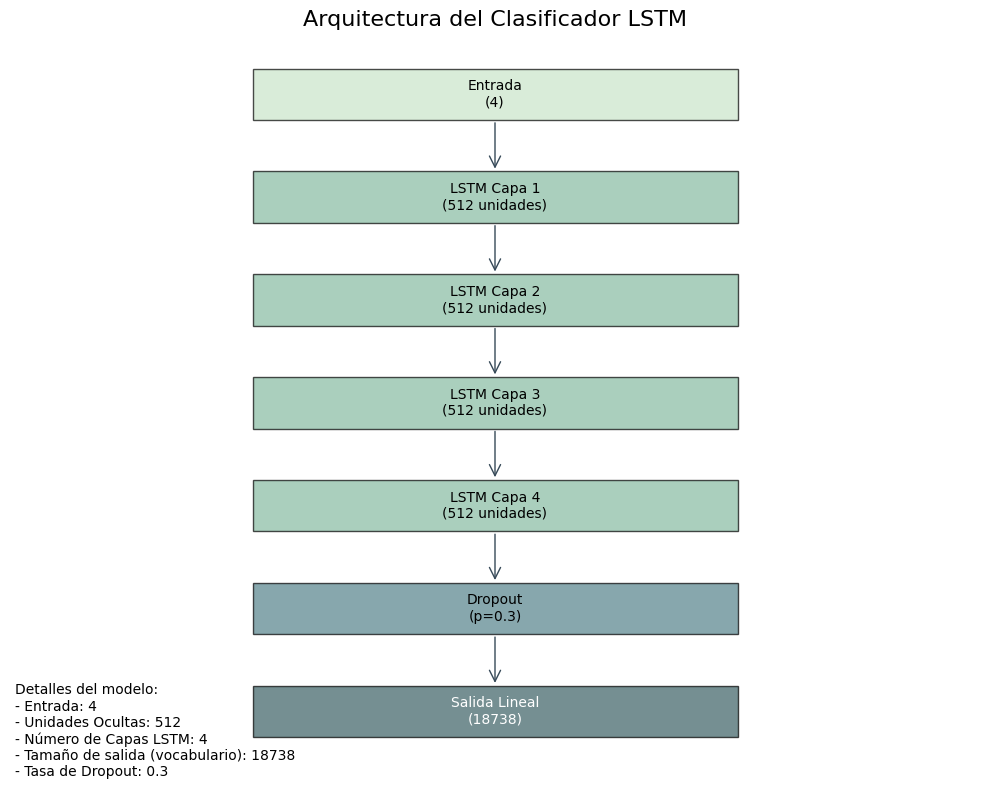

In [23]:
def visualize_model_architecture(
    model_name, input_features=4, hidden_size=512, output_size=None, num_layers=4
):
    """
    Crea una visualización de la arquitectura del modelo.

    Args:
        model_name: String indicando el tipo de modelo ('GRU' o 'LSTM')
        input_features: úmero de características de entrada
        hidden_size: Tamaño de las capas ocultas
        output_size: Size of output layer (vocabulary size for classification)
        num_layers: Number of recurrent layers
    """
    if output_size is None:
        output_size = (
            VOCAB_SIZE  # Usa el tamaño del vocabulario global si no se proporciona
        )

    fig, ax = plt.subplots(figsize=(10, 8))

    # Configuraciones
    box_width = 2
    box_height = 0.6
    y_spacing = 1.2
    x_start = 1

    # Colores
    input_color = "#C9E4CA"
    rnn_color = "#87BBA2"
    dropout_color = "#55828B"
    output_color = "#3B6064"
    arrow_color = "#364958"

    # Dibujar capa de entrada
    ax.add_patch(
        Rectangle(
            (x_start, 5),
            box_width,
            box_height,
            facecolor=input_color,
            edgecolor="black",
            alpha=0.7,
        )
    )
    ax.text(
        x_start + box_width / 2,
        5 + box_height / 2,
        f"Entrada\n({input_features})",
        ha="center",
        va="center",
    )

    # Dibujar capas RNN
    for i in range(num_layers):
        y_pos = 5 - (i + 1) * y_spacing
        ax.add_patch(
            Rectangle(
                (x_start, y_pos),
                box_width,
                box_height,
                facecolor=rnn_color,
                edgecolor="black",
                alpha=0.7,
            )
        )
        ax.text(
            x_start + box_width / 2,
            y_pos + box_height / 2,
            f"{model_name} Capa {i+1}\n({hidden_size} unidades)",
            ha="center",
            va="center",
        )

        # Dibujar flechas entre capas
        if i == 0:
            # Desde la entrada a la primera capa RNN
            arrow = FancyArrowPatch(
                (x_start + box_width / 2, 5),
                (x_start + box_width / 2, y_pos + box_height),
                arrowstyle="->",
                mutation_scale=20,
                color=arrow_color,
            )
        else:
            # Desde la capa RNN anterior
            prev_y_pos = 5 - i * y_spacing
            arrow = FancyArrowPatch(
                (x_start + box_width / 2, prev_y_pos),
                (x_start + box_width / 2, y_pos + box_height),
                arrowstyle="->",
                mutation_scale=20,
                color=arrow_color,
            )
        ax.add_patch(arrow)

    # Dibujar capa de Dropout
    dropout_y = 5 - (num_layers + 1) * y_spacing
    ax.add_patch(
        Rectangle(
            (x_start, dropout_y),
            box_width,
            box_height,
            facecolor=dropout_color,
            edgecolor="black",
            alpha=0.7,
        )
    )
    ax.text(
        x_start + box_width / 2,
        dropout_y + box_height / 2,
        "Dropout\n(p=0.3)",
        ha="center",
        va="center",
    )

    # Dibujar flecha desde la última RNN a Dropout
    last_rnn_y = 5 - num_layers * y_spacing
    arrow = FancyArrowPatch(
        (x_start + box_width / 2, last_rnn_y),
        (x_start + box_width / 2, dropout_y + box_height),
        arrowstyle="->",
        mutation_scale=20,
        color=arrow_color,
    )
    ax.add_patch(arrow)

    # Dibujar capa de salida
    output_y = 5 - (num_layers + 2) * y_spacing
    ax.add_patch(
        Rectangle(
            (x_start, output_y),
            box_width,
            box_height,
            facecolor=output_color,
            edgecolor="black",
            alpha=0.7,
        )
    )
    ax.text(
        x_start + box_width / 2,
        output_y + box_height / 2,
        f"Salida Lineal\n({output_size})",
        ha="center",
        va="center",
        color="white",
    )

    # Dibujar flecha desde Dropout a Salida
    arrow = FancyArrowPatch(
        (x_start + box_width / 2, dropout_y),
        (x_start + box_width / 2, output_y + box_height),
        arrowstyle="->",
        mutation_scale=20,
        color=arrow_color,
    )
    ax.add_patch(arrow)

    # Añadir título e información
    plt.title(f"Arquitectura del Clasificador {model_name}", fontsize=16)

    # Añadir texto explicativo
    info_text = (
        f"Detalles del modelo:\n"
        f"- Entrada: {input_features}\n"
        f"- Unidades Ocultas: {hidden_size}\n"
        f"- Número de Capas {model_name}: {num_layers}\n"
        f"- Tamaño de salida (vocabulario): {output_size}\n"
        f"- Tasa de Dropout: 0.3"
    )
    plt.figtext(0.02, 0.02, info_text, fontsize=10, va="bottom")

    # Limpiar ejes
    ax.set_xlim(0, x_start + box_width + 1)
    ax.set_ylim(output_y - 0.5, 6)
    ax.axis("off")

    plt.tight_layout()
    plt.show()


# Determinar qué modelo tiene mejor perplexity
if "gru_clf_perplexity" in locals() and "lstm_clf_perplexity" in locals():
    best_model = "GRU" if gru_clf_perplexity < lstm_clf_perplexity else "LSTM"
    print(f"Visualizando la mejor arquitectura de modelo: {best_model} Classifier")
    visualize_model_architecture(
        best_model, INPUT_FEATURES, HIDDEN_UNITS, VOCAB_SIZE, num_layers=4
    )
else:
    # Por defecto GRU en caso que no se hayan calculado ambas perplexities
    print("Visualizando la arquitectura del clasificador GRU (por defecto)")
    visualize_model_architecture(
        "GRU", INPUT_FEATURES, HIDDEN_UNITS, VOCAB_SIZE, num_layers=4
    )

## Mejora del desempeño del mejor modelo

In [24]:
# Determinar cuál fue el mejor modelo basado en la perplexidad
if "gru_clf_perplexity" in locals() and "lstm_clf_perplexity" in locals():
    best_model_type = "GRU" if gru_clf_perplexity < lstm_clf_perplexity else "LSTM"
    print(f"El mejor modelo fue: {best_model_type}")
    best_perplexity = min(gru_clf_perplexity.item(), lstm_clf_perplexity.item())
    print(f"Perplexidad base a mejorar: {best_perplexity:.4f}")
else:
    # Si no se han calculado ambas perplejidades, usar el modelo GRU por defecto
    best_model_type = "GRU"
    print(f"Usando modelo {best_model_type} por defecto para tuneo")

# Pipeline de hiperparámetros

# Definir el grid de hiperparámetros a explorar
param_grid = {
    "hidden_size": [256, 512, 768],
    "num_layers": [2, 4, 6],
    "learning_rate": [0.01, 0.001, 0.0005],
    "dropout_rate": [0.2, 0.3, 0.5],
}

# Generar todas las combinaciones de hiperparámetros
param_combinations = list(ParameterGrid(param_grid))
print(f"Se probarán {len(param_combinations)} combinaciones de hiperparámetros")


# Función para crear y entrenar un modelo con hiperparámetros específicos
def train_model_with_params(model_type, params, epochs=5):
    # Crear modelo según el tipo
    if model_type == "GRU":
        model = GRUNet_Classifier(
            input_size=INPUT_FEATURES,
            hidden_size=params["hidden_size"],
            output_size=VOCAB_SIZE,
            num_layers=params["num_layers"],
        )
        # Modificar la tasa de dropout (después de crear el modelo)
        model.dropout.p = params["dropout_rate"]
    else:  # LSTM
        model = LSTMNet_Classifier(
            input_size=INPUT_FEATURES,
            hidden_size=params["hidden_size"],
            output_size=VOCAB_SIZE,
            num_layers=params["num_layers"],
        )
        # Modificar la tasa de dropout (después de crear el modelo)
        model.dropout.p = params["dropout_rate"]

    # Mover el modelo al dispositivo adecuado
    model.to(device)

    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for seqs, labels in dataloader_train_clf:
            seqs, labels = seqs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * seqs.size(0)

        epoch_loss = running_loss / len(dataset_train_clf)
        print(f"Época [{epoch+1}/{epochs}], Pérdida: {epoch_loss:.4f}")

    # Evaluar en conjunto de validación
    val_loss, val_preds, val_targets = evaluate_model_clf(
        model, dataloader_test_clf, criterion, device
    )

    # Calcular perplexidad
    val_preds_tensor = torch.from_numpy(val_preds)
    val_targets_tensor = torch.from_numpy(val_targets).long()
    perplexity = calculate_perplexity(val_preds_tensor, val_targets_tensor).item()

    return model, perplexity


# Realizar búsqueda de hiperparámetros
print(f"Iniciando búsqueda de hiperparámetros para modelo {best_model_type}...")
best_params = None
best_hp_perplexity = float("inf")
best_hp_model = None

# Llevar un registro de resultados para análisis
results = []

# Usar un subconjunto más pequeño del conjunto de parámetros para ahorrar tiempo
# En un entorno de producción, consideraríamos todas las combinaciones
subset_param_combinations = param_combinations[
    :5
]  # Limitar a 5 combinaciones para demostración

for i, params in enumerate(subset_param_combinations):
    print(f"\nPrueba {i+1}/{len(subset_param_combinations)}")
    print(f"Hiperparámetros: {params}")

    model, perplexity = train_model_with_params(best_model_type, params, epochs=3)

    results.append({"params": params, "perplexity": perplexity})

    print(f"Perplexidad: {perplexity:.4f}")

    if perplexity < best_hp_perplexity:
        best_hp_perplexity = perplexity
        best_params = params
        best_hp_model = model

# Ordenar resultados por perplexidad
results_sorted = sorted(results, key=lambda x: x["perplexity"])

print("\n=== RESULTADOS DEL TUNEO DE HIPERPARÁMETROS ===")
print(f"Mejor conjunto de hiperparámetros: {best_params}")
print(f"Mejor perplexidad: {best_hp_perplexity:.4f}")

if best_hp_perplexity < best_perplexity:
    improvement = ((best_perplexity - best_hp_perplexity) / best_perplexity) * 100
    print(f"¡Mejora del {improvement:.2f}% respecto al modelo base!")
else:
    print("No se logró mejorar el modelo base.")

# Visualizar los resultados
print("\nTop 5 combinaciones de hiperparámetros:")
for i, result in enumerate(results_sorted[:5]):
    print(f"{i+1}. Perplexidad: {result['perplexity']:.4f}, Params: {result['params']}")

# Guardar el mejor modelo
if best_hp_model is not None:
    best_model_path = f"best_{best_model_type}_model.pt"
    torch.save(best_hp_model.state_dict(), best_model_path)
    print(f"\nMejor modelo guardado en: {best_model_path}")

El mejor modelo fue: LSTM
Perplexidad base a mejorar: 7275229.5000
Se probarán 81 combinaciones de hiperparámetros
Iniciando búsqueda de hiperparámetros para modelo LSTM...

Prueba 1/5
Hiperparámetros: {'dropout_rate': 0.2, 'hidden_size': 256, 'learning_rate': 0.01, 'num_layers': 2}
Época [1/3], Pérdida: 11.2533
Época [2/3], Pérdida: 12.5779
Época [3/3], Pérdida: 13.3111
Perplexidad: 12655705.0000

Prueba 2/5
Hiperparámetros: {'dropout_rate': 0.2, 'hidden_size': 256, 'learning_rate': 0.01, 'num_layers': 4}
Época [1/3], Pérdida: 11.8068
Época [2/3], Pérdida: 13.1306
Época [3/3], Pérdida: 14.1199
Perplexidad: 6985252.5000

Prueba 3/5
Hiperparámetros: {'dropout_rate': 0.2, 'hidden_size': 256, 'learning_rate': 0.01, 'num_layers': 6}
Época [1/3], Pérdida: 10.9260
Época [2/3], Pérdida: 13.0211
Época [3/3], Pérdida: 12.7844
Perplexidad: 6701731.0000

Prueba 4/5
Hiperparámetros: {'dropout_rate': 0.2, 'hidden_size': 256, 'learning_rate': 0.001, 'num_layers': 2}
Época [1/3], Pérdida: 9.7815
Époc

## Generar música

In [ ]:
def generate_notes_clf(
    model,
    initial_seed,
    num_notes_to_generate,
    device,
    id_to_note_event,
    discretization_mappings,
):
    """
    Generates a sequence of notes using a trained classification model autoregressively.

    Args:
        model (nn.Module): The trained classification model (GRU or LSTM).
        initial_seed (torch.Tensor): A starting sequence of notes (SEQ_LENGTH, 4).
        num_notes_to_generate (int): The total number of note events to generate.
        device (torch.device): 'cuda' or 'cpu'.
        id_to_note_event (dict): Mapping from note event ID to string representation.
        discretization_mappings (dict): Contains bin edge information for inverse transformation.

    Returns:
        list: A list of the 4-feature numpy arrays for each generated note event (discretized values).
              Note: These are the discretized values, not the original continuous ones.
    """
    model.eval()  # Set model to evaluation mode

    # current_sequence shape: (1, SEQ_LENGTH, 4) - Batch size of 1
    current_sequence = initial_seed.unsqueeze(0).to(device)

    generated_notes_list = []

    # Extract mappings needed for inverse transformation
    step_bins = discretization_mappings["step_bins"]
    duration_bins = discretization_mappings["duration_bins"]

    with torch.no_grad():
        for i in range(num_notes_to_generate):
            # 1. Prediction: Get the logits over the vocabulary
            # output shape: (1, VOCAB_SIZE)
            predicted_logits = model(current_sequence)

            # Apply softmax to get probabilities
            probabilities = torch.softmax(predicted_logits, dim=1)

            # Sample a note event ID from the probability distribution
            # Using multinomial sampling for more varied results
            predicted_id = (
                torch.multinomial(probabilities, num_samples=1).squeeze(1).item()
            )

            # 2. Convert predicted ID back to discrete features (pitch, step, duration, velocity)
            # Using the id_to_note_event mapping
            predicted_event_str = id_to_note_event[predicted_id]
            pitch_discrete, step_discrete, duration_discrete, velocity_discrete = map(
                int, predicted_event_str.split("_")
            )

            # Store the generated discrete note features
            generated_notes_list.append(
                np.array(
                    [
                        pitch_discrete,
                        step_discrete,
                        duration_discrete,
                        velocity_discrete,
                    ]
                )
            )

            # 3. Prepare the input for the next prediction

            # Create a tensor from the *discretized* features to feed back into the model
            new_note_features_tensor = (
                torch.tensor(
                    [
                        pitch_discrete,
                        step_discrete,
                        duration_discrete,
                        velocity_discrete,
                    ]
                )
                .float()
                .unsqueeze(0)
                .unsqueeze(0)
                .to(device)
            )

            # Append the new note features and drop the oldest note features
            # new_sequence shape: (1, SEQ_LENGTH, 4)
            current_sequence = torch.cat(
                (current_sequence[:, 1:, :], new_note_features_tensor), dim=1
            )

    return generated_notes_list

In [ ]:
def notes_to_audio_file_clf(
    generated_notes_discrete,
    output_path,
    instrument_name="Acoustic Grand Piano",
    discretization_mappings=None,
):
    """
    Converts a list of generated discrete note features into a MIDI file.
    (WAV conversion can be done separately from the MIDI file)

    Args:
        generated_notes_discrete (list): List of 4-feature numpy arrays for each generated note
                                         (discretized pitch, step bin, duration bin, velocity).
        output_path (str): Path to save the output MIDI file (e.g., 'song_1.mid').
        instrument_name (str): MIDI instrument name.
        discretization_mappings (dict): Contains bin edge information for inverse transformation.
    """
    pm = pretty_midi.PrettyMIDI()

    try:
        program = pretty_midi.instrument_name_to_program(instrument_name)
    except ValueError:
        print(
            f"Warning: Instrument '{instrument_name}' not found. Using default 'Acoustic Grand Piano'."
        )
        program = pretty_midi.instrument_name_to_program("Acoustic Grand Piano")

    instrument = pretty_midi.Instrument(program=program)

    current_time = 0.0  # Start time of the first note

    # Ensure discretization_mappings are provided for inverse transformation
    if discretization_mappings is None:
        print(
            "Error: Discretization mappings are required for converting bins back to continuous values."
        )
        return

    step_bins = discretization_mappings["step_bins"]
    duration_bins = discretization_mappings["duration_bins"]

    for note_features_discrete in generated_notes_discrete:
        pitch_discrete, step_discrete_bin, duration_discrete_bin, velocity_discrete = (
            note_features_discrete.astype(int)
        )

        # Inverse transform the discrete bins back to approximate continuous values
        # Use the midpoint of the bin for a continuous representation
        try:
            # Step: use the midpoint of the bin
            step = (step_bins[step_discrete_bin] + step_bins[step_discrete_bin + 1]) / 2
        except IndexError:
            # If it's the last bin, just use the lower bound
            step = step_bins[step_discrete_bin]
        except TypeError:
            # Handle cases where step_bins might not be numeric (shouldn't happen with qcut)
            step = 0.1  # Default or handle appropriately

        try:
            # Duration: use the midpoint of the bin
            duration = (
                duration_bins[duration_discrete_bin]
                + duration_bins[duration_discrete_bin + 1]
            ) / 2
        except IndexError:
            # If it's the last bin, just use the lower bound
            duration = duration_bins[duration_discrete_bin]
        except TypeError:
            # Handle cases where duration_bins might not be numeric
            duration = 0.1  # Default or handle appropriately

        # Pitch and Velocity are already approximately continuous after rounding, use them directly
        pitch = pitch_discrete
        velocity = velocity_discrete

        # Ensure step and duration are positive
        step = max(0.01, step)
        duration = max(0.01, duration)

        # 1. Calculate Start Time: Advance the time by the 'step' (time since last note ended)
        current_time += step
        start = current_time

        # 2. Calculate End Time: Add the 'duration' to the start time
        end = start + duration

        # 3. Create the PrettyMIDI Note object
        # Ensure pitch and velocity are integers as required by pretty_midi
        note = pretty_midi.Note(
            velocity=int(velocity), pitch=int(pitch), start=start, end=end
        )

        instrument.notes.append(note)

        # 4. Update the time pointer: The next note's 'step' is added from *this* note's end
        current_time = end

    pm.instruments.append(instrument)

    # Guardar el archivo midi
    midi_path = output_path + ".mid"
    pm.write(midi_path)
    print(f"Archivo midi almacenado en: {midi_path}")

    # Convertir a WAV
    wav_path = output_path + ".wav"
    fs = FluidSynth()
    fs.midi_to_audio(midi_path, wav_path)
    print(f"Archivo Wav almacenado en : {wav_path}")

In [ ]:
NUM_NOTES = 200

# Assuming X_train is your original (30804, 32, 4) data tensor
# Ensure these indices are far apart to get distinct musical starting points.
seed_index_1 = 0  # First 32 notes
seed_index_2 = 8000  # A sequence later in the dataset
seed_index_3 = 15000  # Another sequence much later

seed_1 = X_train_clf_np[seed_index_1]  # shape (32, 4)
seed_2 = X_train_clf_np[seed_index_2]  # shape (32, 4)
seed_3 = X_train_clf_np[seed_index_3]  # shape (32, 4)

# Create a list of seeds
seeds = [seed_1, seed_2, seed_3]
seeds = [seed_1, seed_2, seed_3]
output_paths = [
    "/content/dataset/generated_song_1",
    "/content/dataset/generated_song_2",
    "/content/dataset/generated_song_3",
]

for i, seed_np in enumerate(seeds):
    print(f"\n--- Generando canción {i+1} con semilla {i+1} ---")
    seed_tensor = torch.from_numpy(seed_np).float()
    generated_notes = generate_notes_clf(
        model_lstm_clf,
        seed_tensor,
        NUM_NOTES,
        device,
        id_to_note_event=discretization_mappings["id_to_note_event"],
        discretization_mappings=discretization_mappings,
    )

    # 2. Convert to WAV file
    notes_to_audio_file_clf(
        generated_notes,
        output_paths[i],
        discretization_mappings=discretization_mappings,
    )


--- Generando canción 1 con semilla 1 ---
Archivo midi almacenado en: /content/dataset/generated_song_1.mid
Archivo Wav almacenado en : /content/dataset/generated_song_1.wav

--- Generando canción 2 con semilla 2 ---
Archivo midi almacenado en: /content/dataset/generated_song_2.mid
Archivo Wav almacenado en : /content/dataset/generated_song_2.wav

--- Generando canción 3 con semilla 3 ---
Archivo midi almacenado en: /content/dataset/generated_song_3.mid
Archivo Wav almacenado en : /content/dataset/generated_song_3.wav


Visualizing generated waveforms:


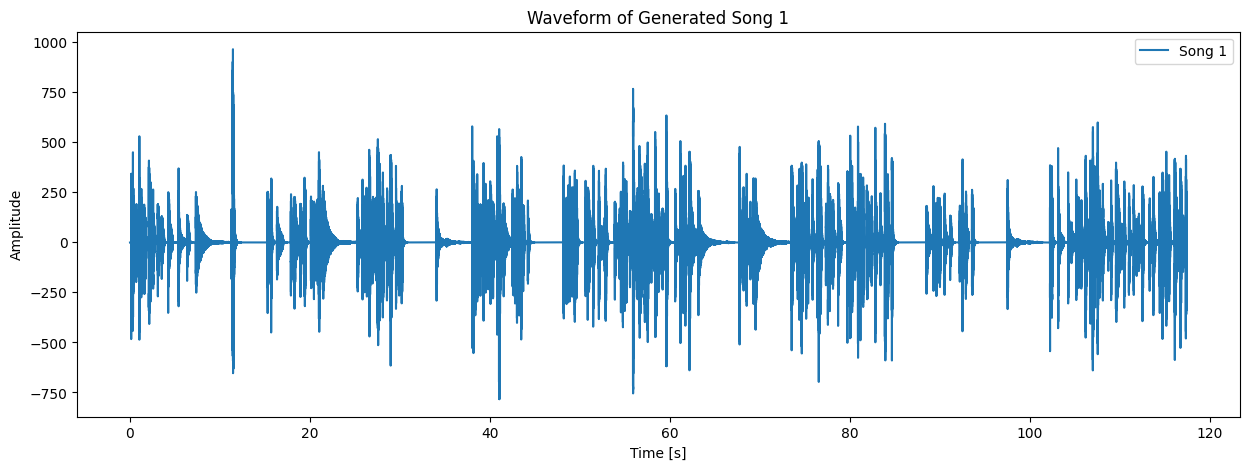

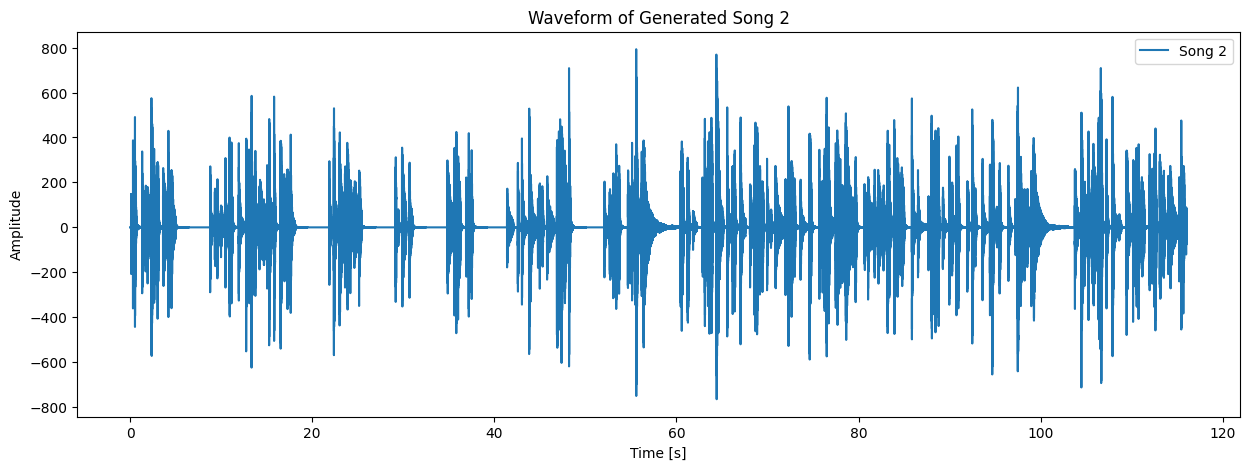

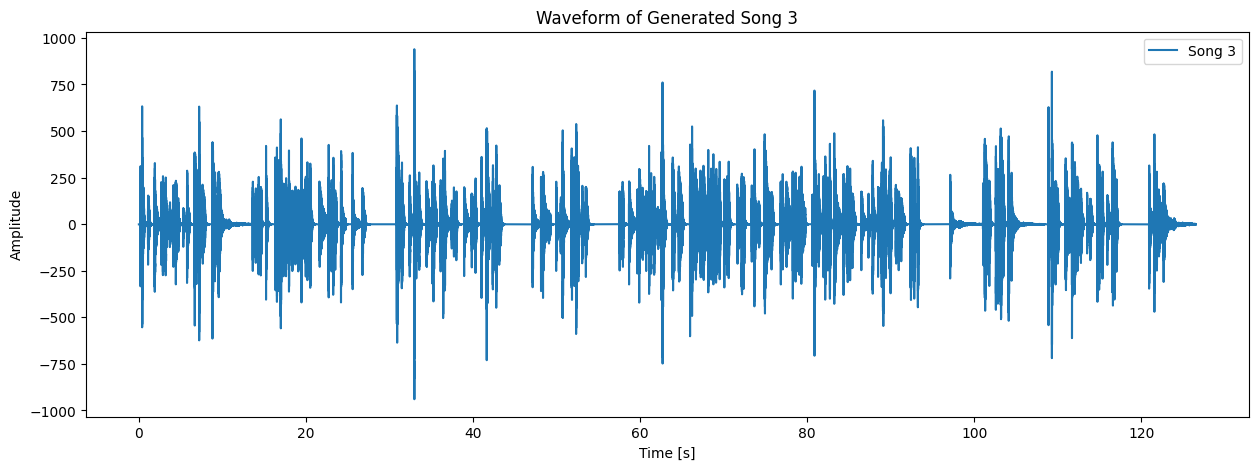

In [ ]:
## Visualización de los archivos generados

print("Visualizando wavs:")
for i, output_path in enumerate(output_paths):
    wav_path = f"{output_path}.wav"
    try:
        rate, data = wavfile.read(wav_path)

        if len(data.shape) > 1:
            data = np.mean(data, axis=1)

        time = np.linspace(0.0, len(data) / rate, len(data))

        plt.figure(figsize=(15, 5))
        plt.plot(time, data, label=f"Canción {i+1}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.title(f"Forma de onda de canción generada {i+1}")
        plt.legend()
        plt.show()

    except FileNotFoundError:
        print(f"Error: archivo wav no encontrado {wav_path}")
    except Exception as e:
        print(f"Un error ocurrió porcesando el archivo {wav_path}: {e}")